In [10]:
import pandas as pd
import numpy as np
import patsy
import warnings
import statsmodels.api as sm
import copy
from scipy.stats import norm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.simplefilter('ignore')
np.random.seed(1234)

In [11]:
# set up double lasso library
#! pip install multiprocess
#! git clone https://github.com/maxhuppertz/hdmpy.git
import sys
sys.path.insert(1, "./hdmpy")

# We wrap the package so that it has the familiar sklearn API
import hdmpy
from sklearn.base import BaseEstimator


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])


def lasso_model():
    return RLasso(post=False)

### Assignment 1: Causal Analysis of College Degree Attainment on Wages

In [12]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)
y = np.log(data["wage"]).values
Z = data.drop(["wage", "lwage"], axis=1)

X_baseline_full = patsy.dmatrix(
    "clg + sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2)",
    data,
    return_type="dataframe"
)
# a.) partialling out predictive effect of clg
X_baseline = X_baseline_full.drop(columns="Intercept")

clg = X_baseline["clg"]
X_no_clg = X_baseline.drop(columns="clg")

clg_model = sm.OLS(clg, sm.add_constant(X_no_clg)).fit(cov_type='HC1')
d_hat = clg_model.resid

y_model = sm.OLS(y, sm.add_constant(X_no_clg)).fit(cov_type='HC1')
y_hat = y_model.resid

final_baseline_model = sm.OLS(y_hat, d_hat).fit(cov_type='HC1')
ci_baseline = final_baseline_model.conf_int()
ape_baseline = final_baseline_model.params[0]
ci_baseline = ci_baseline.reset_index()

print(f"Coefficient (predictive clg effect) in OLS without interactions: {ape_baseline:.4f}")
print(f"95% CI: [{float(ci_baseline.iloc[0, 1]):.4f}, {float(ci_baseline.iloc[0, 2]):.4f}]")

X_interactions_full = patsy.dmatrix(
    "(clg + sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2",
    data,
    return_type="dataframe"
)
X_interactions = X_interactions_full.drop(columns="Intercept")
X_interactions_no_clg = X_interactions.drop(columns="clg")

clg_int_model = sm.OLS(clg, sm.add_constant(X_interactions_no_clg)).fit(cov_type='HC1')
d_hat_int = clg_int_model.resid

y_int_model = sm.OLS(y, sm.add_constant(X_interactions_no_clg)).fit(cov_type='HC1')
y_hat_int = y_int_model.resid
final_interactions_model = sm.OLS(y_hat_int, d_hat_int).fit(cov_type='HC1')

ape_interactions = final_interactions_model.params[0]
ci_interactions = final_interactions_model.conf_int()
ci_interactions = ci_interactions.reset_index()
print(f"Coefficient (predictive clg effect) in OLS with interactions: {ape_interactions:.4f}")
print(f"95% CI: [{float(ci_interactions.iloc[0, 1]):.4f}, {float(ci_interactions.iloc[0, 2]):.4f}]")

# a.) same with double lasso regression

lasso_first = lasso_model()
lasso_first.fit(sm.add_constant(X_interactions_no_clg), clg)
d_hat_lasso = lasso_first.predict(sm.add_constant(X_interactions_no_clg))
d_hat_lasso = clg - d_hat_lasso
lasso_second = lasso_model()
lasso_second.fit(sm.add_constant(X_interactions_no_clg), y)
y_hat_lasso = lasso_second.predict(sm.add_constant(X_interactions_no_clg))
y_hat_lasso = y - y_hat_lasso

final_lasso_model = sm.OLS(y_hat_lasso, d_hat_lasso).fit(cov_type='HC1')
ape_lasso = final_lasso_model.params[0]
ci_lasso = final_lasso_model.conf_int()
ci_lasso = ci_lasso.reset_index()

print(f"Coefficient (predictive clg effect) in double lasso with interactions: {ape_lasso:.4f}")
print(f"95% CI: [{float(ci_lasso.iloc[0, 1]):.4f}, {float(ci_lasso.iloc[0, 2]):.4f}]")

Coefficient (predictive clg effect) in OLS without interactions: 0.1329
95% CI: [0.1008, 0.1649]
Coefficient (predictive clg effect) in OLS with interactions: 0.6403
95% CI: [0.2761, 1.0044]
Coefficient (predictive clg effect) in double lasso with interactions: 0.5508
95% CI: [0.2637, 0.8380]


In [13]:
# b.) 
from  sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
X_all_interactions = patsy.dmatrix(
    "1 + clg + clg*(sex + mw + so + we + exp1 + exp2 + exp3 + exp4) + (sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2",
    data, return_type="dataframe")
X_all_interactions = X_all_interactions.drop(columns="Intercept")
clg_all_interactions = X_all_interactions["clg"].copy()
X_all_interactions_no_clg = X_all_interactions.drop(columns="clg")
clg_interaction_cols = [col for col in X_all_interactions.columns if "clg" in col]

linreg = sm.OLS(y, X_all_interactions).fit(cov_type='HC1')
alphas_lasso = np.logspace(-3, 2, 20)
lasso_cv = LassoCV(cv=5, alphas=alphas_lasso, random_state=0)
lasso_cv.fit(X_all_interactions, y)

rlasso_model = lasso_model().fit(X_all_interactions, y)

alphas_enet = np.logspace(-3, 2, 20)
enet_model = ElasticNetCV(cv=5, alphas=alphas_enet, l1_ratio=[0.5], random_state=0)
enet_model.fit(X_all_interactions, y)
enet_coefs = pd.Series(enet_model.coef_, index=X_all_interactions.columns)

alphas_ridge = np.logspace(-3, 2, 20)
ridge_model = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_model.fit(X_all_interactions, y)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_all_interactions.columns)

ols_coefs = pd.Series(linreg.params, index=X_all_interactions.columns)
lasso_cv_coefs = pd.Series(lasso_cv.coef_, index=X_all_interactions.columns)
rlasso_coefs = pd.Series(rlasso_model.rlasso_.est["beta"].loc[clg_interaction_cols, 0])

print("=== OLS Coefficients for clg Interactions ===")
print(ols_coefs[clg_interaction_cols])

print("\n=== LassoCV Coefficients for clg Interactions ===")
print(lasso_cv_coefs[clg_interaction_cols])

print("\n=== Rlasso Coefficients for clg Interactions ===")
print(rlasso_coefs[clg_interaction_cols])

print("\n=== ElasticNetCV Coefficients for clg Interactions ===")
print(enet_coefs[clg_interaction_cols])

print("\n=== RidgeCV Coefficients for clg Interactions ===")
print(ridge_coefs[clg_interaction_cols])

=== OLS Coefficients for clg Interactions ===
clg        -0.043439
clg:sex     0.014940
clg:mw      0.016496
clg:so     -0.014717
clg:we     -0.065194
clg:exp1    0.058144
clg:exp2   -0.563291
clg:exp3    0.207276
clg:exp4   -0.025254
dtype: float64

=== LassoCV Coefficients for clg Interactions ===
clg         0.081020
clg:sex     0.000000
clg:mw      0.026480
clg:so      0.000000
clg:we     -0.033253
clg:exp1    0.009084
clg:exp2   -0.000000
clg:exp3   -0.017843
clg:exp4    0.003186
dtype: float64

=== Rlasso Coefficients for clg Interactions ===
clg         0.105298
clg:sex     0.000000
clg:mw      0.000000
clg:so      0.000000
clg:we      0.000000
clg:exp1    0.001979
clg:exp2    0.000000
clg:exp3    0.000000
clg:exp4    0.000000
Name: 0, dtype: float64

=== ElasticNetCV Coefficients for clg Interactions ===
clg         0.079949
clg:sex     0.000000
clg:mw      0.027773
clg:so      0.000000
clg:we     -0.034307
clg:exp1    0.009261
clg:exp2   -0.001245
clg:exp3   -0.017424
clg:exp4

1. Ordinary Least Squares (OLS) Coefficients:  
  
clg        -0.043439  
clg:sex     0.014940  
clg:mw      0.016496  
clg:so     -0.014717  
clg:we     -0.065194  
clg:exp1    0.058144  
clg:exp2   -0.563291  
clg:exp3    0.207276  
clg:exp4   -0.025254  
  
Inductive Bias:  
OLS imposes no penalty on coefficients. It simply picks parameter estimates to minimize the residual sum of squares (subject to the constraints, if any).  

Effect:  
All coefficients can freely vary, which often leads to a lack of sparsity. None are forced to zero unless the data themselves perfectly identify a coefficient as zero (which is rare).
Some coefficients can become relatively large in magnitude. Indeed, we see a strong negative coefficient for clg:exp2 in OLS, which gets heavily shrunk in other methods.  
  
2. LassoCV Coefficients:  
  
clg         0.081020  
clg:sex     0.000000  
clg:mw      0.026480  
clg:so      0.000000  
clg:we     -0.033253  
clg:exp1    0.009084  
clg:exp2   -0.000000  
clg:exp3   -0.017843  
clg:exp4    0.003186  
Several coefficients have been driven exactly to zero, such as clg:sex, clg:so, and clg:exp2.  

Inductive Bias:  
Lasso (L1 penalty) encourages sparsity (coefficients to be exactly zero) by penalizing the absolute size of the coefficients.
In cross-validation, the model picks an alpha (regularization strength) that balances fit versus sparsity.  
  
Effect:  
Some interaction terms (e.g., clg:sex, clg:so, clg:exp2) are set to exactly zero, implying that the model found them less important in explaining the outcome once the regularization and cross-validation were taken into account.
The remaining coefficients are generally shrunk relative to OLS, though sometimes a coefficient can increase slightly if dropping other terms frees up the model to place more weight on fewer predictors.  
  
3. Rlasso Coefficients:  
  
clg         0.105298  
clg:sex     0.000000  
clg:mw      0.000000  
clg:so      0.000000  
clg:we      0.000000  
clg:exp1    0.001979  
clg:exp2    0.000000  
clg:exp3    0.000000
clg:exp4    0.000000  
This is even more sparse than the LassoCV result. Only clg and clg:exp1 remain non-zero.  
  
Inductive Bias:  
  
Rlasso (as implemented in the hdm package in R or similar theoretical constructions in Python) uses a theoretically derived penalty that accounts for sample size and other factors. It is designed to do strong variable selection under high-dimensional setups or when one wants rigorous post-selection inference.  
  
Effect:  
An even higher degree of sparsity is typical, because the method is quite strict in testing which variables remain in the model. In the example, it leaves only the main clg term and clg:exp1 as non-zero.
Coefficients can differ from standard LassoCV because the penalty and selection procedure are computed differently.  
  
4. ElasticNetCV Coefficients:  
  
clg         0.079949  
clg:sex     0.000000  
clg:mw      0.027773  
clg:so      0.000000  
clg:we     -0.034307  
clg:exp1    0.009261  
clg:exp2   -0.001245  
clg:exp3   -0.017424  
clg:exp4    0.003147  
Similar to LassoCV in that some coefficients go exactly to zero, though a few more remain non-zero. For example, clg:exp2 is tiny (not zero) rather than exactly zero.  
  
Inductive Bias:  
  
ElasticNet (combination of L1 and L2 penalties) tries to achieve a balance between:  
The sparsity effect from L1 (like Lasso).  
The shrinkage effect from L2 (like Ridge).  
  
Effect:  
Some coefficients remain zero (like clg:sex and clg:so), suggesting that the L1 component is strong enough for those to drop out.
Other coefficients (e.g. clg:exp2) are only partially shrunk instead of being dropped entirely, indicating the interplay of L1 and L2 penalty often keeps small but non-zero coefficients rather than fully eliminating them.  
  
5. RidgeCV Coefficients:  
  
clg         0.037517  
clg:sex     0.010081  
clg:mw      0.031330  
clg:so      0.013547  
clg:we     -0.035292  
clg:exp1    0.016245  
clg:exp2   -0.034290  
clg:exp3   -0.016545  
clg:exp4    0.004225  
No coefficients are set to zero; all are “shrunk” compared to OLS.  
  
Inductive Bias:  
  
Ridge (L2 penalty) penalizes the squared magnitude of coefficients. This shrinks all coefficients towards zero but never sets any coefficient exactly to zero.  
  
Effect:  
All interaction terms remain in the model, although each is typically smaller in absolute value compared to OLS (especially if the unpenalized OLS estimate was large).
The penalty encourages distributing the effect among more predictors rather than dropping them.

In [14]:
# c.) Same with double lasso
double_lasso_coefficients = {}
dl_resids = {}
res_d_hat = {}
res_y_hat = {}
alpha = {}
for term in clg_interaction_cols:
    X_all_interactions_temp = copy.deepcopy(X_all_interactions)
    X_all_interactions_temp = X_all_interactions_temp.drop(columns=term)
    lasso_first = lasso_model()
    lasso_first.fit(X_all_interactions_temp, X_all_interactions[term])
    d_hat_lasso = lasso_first.predict(X_all_interactions_temp)
    d_hat_lasso = X_all_interactions[term] - d_hat_lasso
    res_d_hat[term] = d_hat_lasso
    lasso_second = lasso_model()
    lasso_second.fit(X_all_interactions_temp, y)
    y_hat_lasso = lasso_second.predict(X_all_interactions_temp)
    y_hat_lasso = y - y_hat_lasso
    res_y_hat[term] = y_hat_lasso
    final_lasso_model = sm.OLS(y_hat_lasso, d_hat_lasso).fit(cov_type='HC1')
    double_lasso_coefficients[term] = final_lasso_model.params[0]
    dl_resids[term] = final_lasso_model.resid
    alpha[term] = [final_lasso_model.params[0]]
print("\n=== Double Lasso Coefficients for clg Interactions ===")
print(pd.Series(double_lasso_coefficients))


=== Double Lasso Coefficients for clg Interactions ===
clg         0.144060
clg:sex     0.003882
clg:mw      0.051519
clg:so     -0.000788
clg:we     -0.066616
clg:exp1    0.012592
clg:exp2    0.037757
clg:exp3   -0.018984
clg:exp4   -0.008072
dtype: float64


The coefficients are different to the ones we see in lassoCV. There is no exact zeroing out of coefficients. Interestingly, out of the coefficients zerod out by LassoCV (clg:sex, clg:so, clg:exp2) the first two are shrunk to small values in double lasso, but the double lasso coefficient for clg:exp2 is bigger than some coefficients that were not shrunk to zero by lassoCV(e.g. the clg interactions with other exp terms).

In [15]:
# d.) joint confidence intervals
V = np.zeros((len(clg_interaction_cols), len(clg_interaction_cols)))
for it, c in enumerate(clg_interaction_cols):
    Jc = np.mean(res_d_hat[c]**2)
    for itp, cp in enumerate(clg_interaction_cols):
        Jcp = np.mean(res_d_hat[cp]**2)
        Sigma = np.mean(res_d_hat[c] *dl_resids[c] *dl_resids[cp] *res_d_hat[cp])
        V[it, itp] = Sigma / (Jc * Jcp)
print(f"Diagonal of V: {np.diag(V)}")

n = X_all_interactions.shape[0]
for it, c in enumerate(clg_interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]
print(alpha)
# put all in a dataframe
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])

# Calculate and pointwise p-value
summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['Std. Error'] = df['stderr']
summary['p-value'] = norm.sf(np.abs(df['point'] / df['stderr']), loc=0, scale=1) * 2
summary['ci_lower'] = df['point'] - 1.96 * df['stderr']
summary['ci_upper'] = df['point'] + 1.96 * df['stderr']

Drootinv = np.diagflat(1 / np.sqrt(np.diag(V)))
scaledCov = Drootinv @ V @ Drootinv
np.random.seed(123)
U = np.random.multivariate_normal(np.zeros(scaledCov.shape[0]), scaledCov, size=10000)
z = np.max(np.abs(U), axis=1)
c = np.percentile(z, 95)

summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['CI lower'] = df['point'] - c * df['stderr']
summary['CI upper'] = df['point'] + c * df['stderr']
summary



Diagonal of V: [ 8.76018317  4.86679139  9.82624944  8.48567327  9.30116675  0.3420579
 22.14819433  7.25429584  0.03362653]
{'clg': [np.float64(0.14406033358245535), np.float64(0.041243259334373075)], 'clg:sex': [np.float64(0.0038820966929447665), np.float64(0.03074098302429507)], 'clg:mw': [np.float64(0.05151943575267605), np.float64(0.043680769214725315)], 'clg:so': [np.float64(-0.0007880882745683656), np.float64(0.040591914795774155)], 'clg:we': [np.float64(-0.06661629783139925), np.float64(0.042497668132571796)], 'clg:exp1': [np.float64(0.012592469363026963), np.float64(0.008149785877781224)], 'clg:exp2': [np.float64(0.037756929658739634), np.float64(0.06557911450146418)], 'clg:exp3': [np.float64(-0.018984077707718428), np.float64(0.03753133537366912)], 'clg:exp4': [np.float64(-0.0080715697856425), np.float64(0.002555273482863417)]}


,Estimate,CI lower,CI upper
clg,0.144060,0.031939,0.256181
clg:sex,0.003882,-0.079688,0.087452
clg:mw,0.051519,-0.067228,0.170267
clg:so,-0.000788,-0.111138,0.109562
clg:we,-0.066616,-0.182147,0.048915
clg:exp1,0.012592,-0.009563,0.034748
clg:exp2,0.037757,-0.140522,0.216035
clg:exp3,-0.018984,-0.121014,0.083046
clg:exp4,-0.008072,-0.015018,-0.001125


### Assignment 2

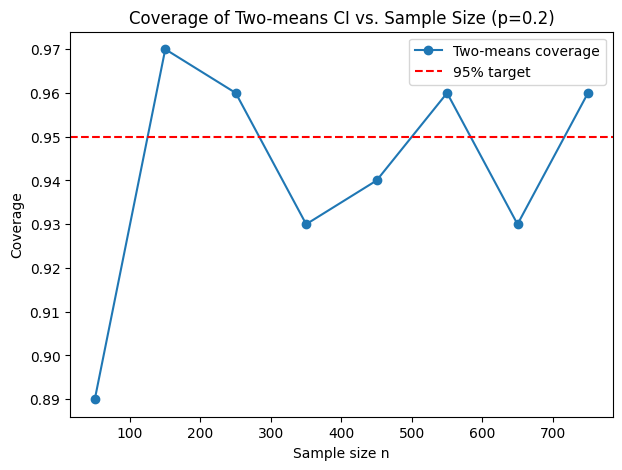

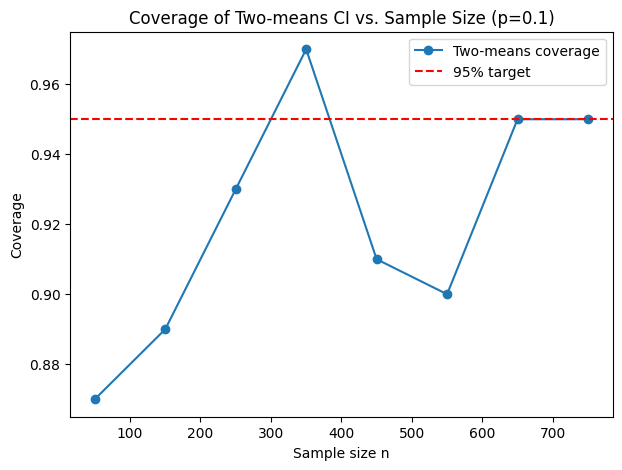

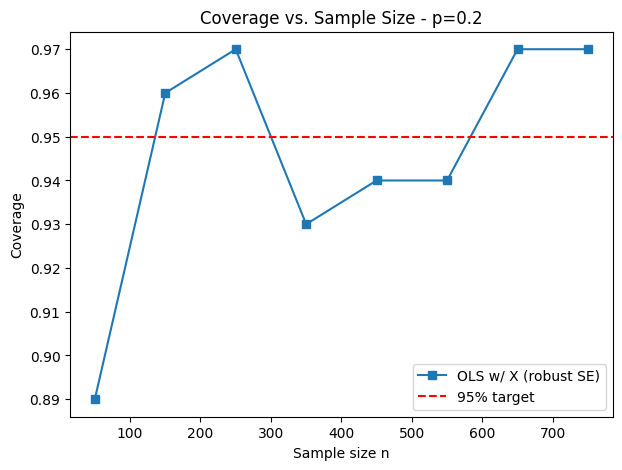

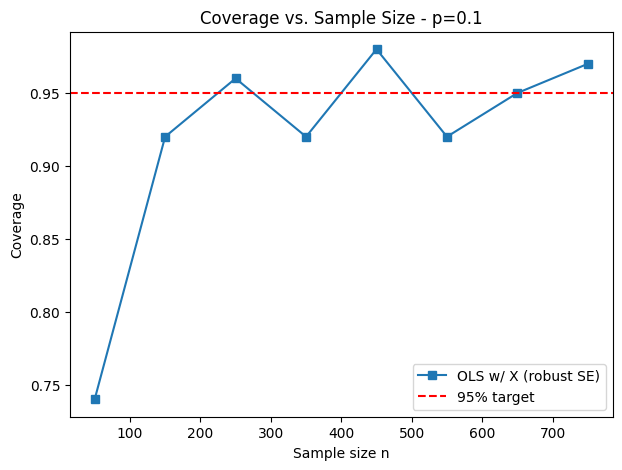

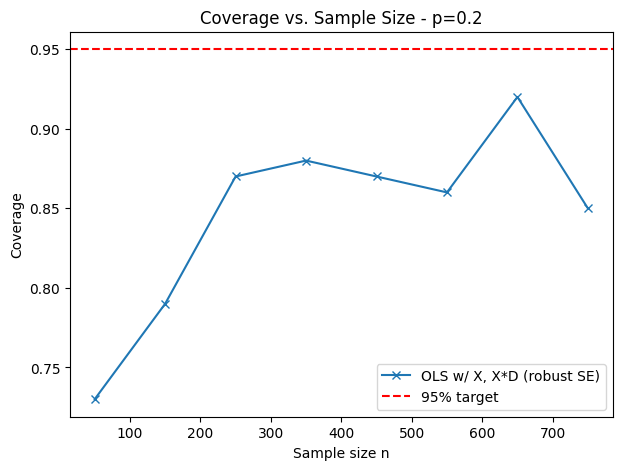

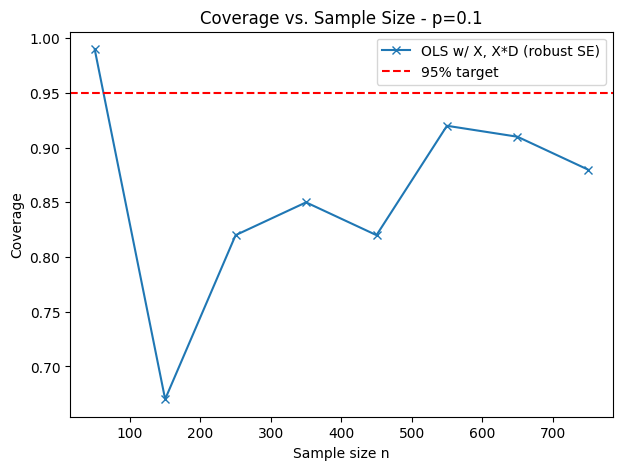

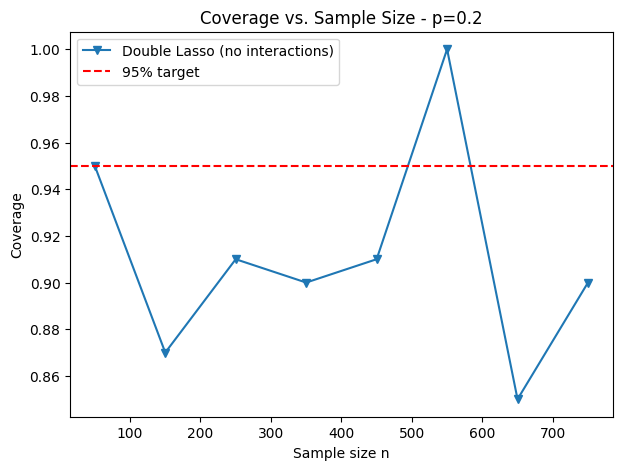

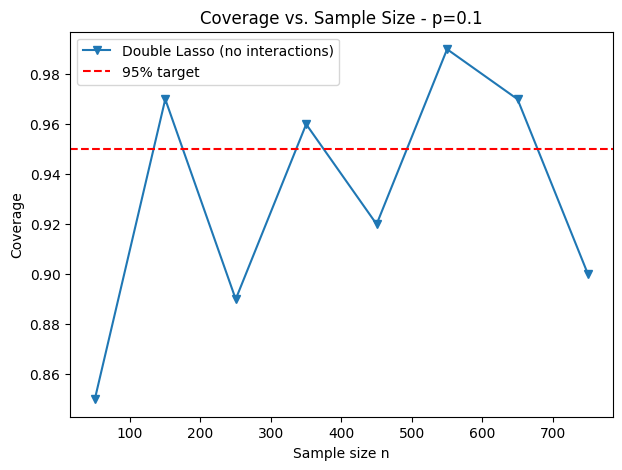

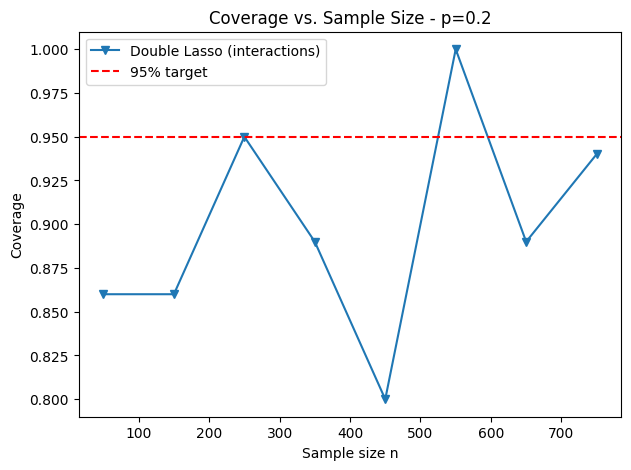

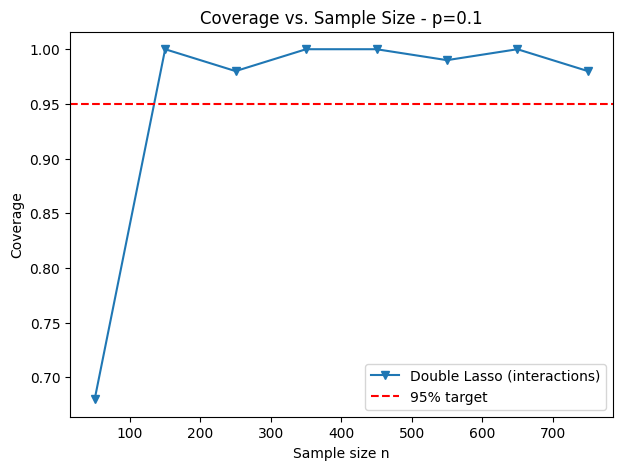

In [28]:
from sklearn.linear_model import LinearRegression

def gen_data(n, d, p, delta, base):
    """
    n: sample size
    d: number of covariates
    p: probability of treatment
    delta: true treatment effect
    base: baseline response
    
    Returns:
        y (n-vector): outcome
        D (n-vector): treatment indicator
        X (n x d): covariates
    """
    D = np.random.binomial(1, p, size=n)
    X = np.random.normal(0, 1, size=(n, d))
    
    # Potential outcomes:
    #  Y(0) = base - X[:,0] + noise
    #  Y(1) = delta + base + X[:,0] + noise
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=n)
    y1 = delta + base + X[:, 0] + np.random.normal(0, 1, size=n)
    
    # Observed outcome:
    y = D * y1 + (1 - D) * y0
    return y, D, X

n_grid = [50, 150, 250, 350, 450, 550, 650, 750]
reps = 100
delta_true = 1.0      # given
d = 10                # dimensionality of X
base = 0.3            # baseline


def two_means_estimate(y, D):
    """
    Returns (estimate, se) for the two-means difference in y between treated and untreated.
    """
    treat_mask = (D == 1)
    control_mask = (D == 0)
    
    n1 = treat_mask.sum()
    n0 = control_mask.sum()
    
    y1_bar = np.mean(y[treat_mask])
    y0_bar = np.mean(y[control_mask])
    tau_hat = y1_bar - y0_bar
    
    # sample variances
    V1 = np.var(y[treat_mask]) / np.mean(D)
    V0 = np.var(y[control_mask]) / np.mean(1-D)
    
    # standard error
    se = np.sqrt((V1+V0) / (n1+n0))
    return tau_hat, se


def run_two_means_estimate(p):

    coverage_results_2means = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            
            tau_hat, se = two_means_estimate(y, D)
            # 95% CI:
            ci_lower = tau_hat - 1.96 * se
            ci_upper = tau_hat + 1.96 * se
            
            # Check coverage:
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1

        coverage = covered_count / reps
        coverage_results_2means.append(coverage)

    # Plot coverage:
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_2means, marker='o', label='Two-means coverage')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage of Two-means CI vs. Sample Size (p={p})')
    plt.legend()
    plt.show()

run_two_means_estimate(0.2)
run_two_means_estimate(0.1)


def ols_with_covariates(y, D, X):
    X = X - X.mean(axis=0)
    yres = y - LinearRegression().fit(X, y).predict(X)
    Dres = D - LinearRegression().fit(X, D).predict(X)
    tau_hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - tau_hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    tau_se = np.sqrt(V / y.shape[0])
    return tau_hat, tau_se

def run_ols_with_covariates(p):
    coverage_results_ols = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            
            tau_hat, tau_se = ols_with_covariates(y, D, X)
            
            ci_lower = tau_hat - 1.96 * tau_se
            ci_upper = tau_hat + 1.96 * tau_se
            
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_ols = covered_count / reps
        coverage_results_ols.append(coverage_ols)

    # Plot coverage
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_ols, marker='s', label='OLS w/ X (robust SE)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()
    
run_ols_with_covariates(0.2)
run_ols_with_covariates(0.1)


def ols_with_interactions(y, D, X):
    X = X - X.mean(axis=0)
    DX = D.reshape(-1,1) * X
    W = np.column_stack([X, DX])
    yres = y - LinearRegression().fit(W, y).predict(W)
    Dres = D - LinearRegression().fit(W, D).predict(W)
    tau_hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - tau_hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    tau_se = np.sqrt(V / y.shape[0])
    return tau_hat, tau_se


def run_ols_with_interactions(p):
    coverage_results_ols_inter = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            tau_hat, tau_se = ols_with_interactions(y, D, X)
            
            ci_lower = tau_hat - 1.96 * tau_se
            ci_upper = tau_hat + 1.96 * tau_se
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_results_ols_inter.append(covered_count / reps)
        
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_ols_inter, marker='x', label='OLS w/ X, X*D (robust SE)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()

run_ols_with_interactions(0.2)
run_ols_with_interactions(0.1)

def run_double_lasso_no_interactions(p):
    coverage_results_dl = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            X = X - X.mean(axis=0)  # demean covariates
            X_design = np.column_stack([D, X])
            
            lasso_first = lasso_model()
            lasso_first.fit(X_design, D)
            D_hat = lasso_first.predict(X_design)
            D_resid = D - D_hat
            
            lasso_second = lasso_model()
            lasso_second.fit(X_design, y)
            y_hat = lasso_second.predict(X_design)
            y_resid = y - y_hat
            
            final_model = sm.OLS(y_resid, D_resid).fit(cov_type='HC1')
            tau_hat = final_model.params[0]
            ci_lower = tau_hat - 1.96 * final_model.bse[0]
            ci_upper = tau_hat + 1.96 * final_model.bse[0]
            
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_results_dl.append(covered_count / reps)
        
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_dl, marker='v', label='Double Lasso (no interactions)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()
    
run_double_lasso_no_interactions(0.2)
run_double_lasso_no_interactions(0.1)


def run_double_lasso_with_interactions(p):
    coverage_results_dl_inter = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            X = X - X.mean(axis=0)  # demean covariates
            X_design = patsy.dmatrix("D + X + D*X", {"D": D, "X": X})
            
            lasso_first = lasso_model()
            lasso_first.fit(X_design, D)
            D_hat = lasso_first.predict(X_design)
            D_resid = D - D_hat
            
            lasso_second = lasso_model()
            lasso_second.fit(X_design, y)
            y_hat = lasso_second.predict(X_design)
            y_resid = y - y_hat
            
            final_model = sm.OLS(y_resid, D_resid).fit(cov_type='HC1')
            tau_hat = final_model.params[0]
            ci_lower = tau_hat - 1.96 * final_model.bse[0]
            ci_upper = tau_hat + 1.96 * final_model.bse[0]
            
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_results_dl_inter.append(covered_count / reps)
        
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_dl_inter, marker='v', label='Double Lasso (interactions)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()
    
run_double_lasso_with_interactions(0.2)
run_double_lasso_with_interactions(0.1)

a.) For all experiments, we are targeting the coverage to be 95%, since we are calculating a 95% confidence interval.  
  
For the simple two-means estimate at p=0.2, the coverage reaches the desired level at a sample size of 150.  
For the two-means estimate at p=0.1, the threshold is reached at a sample size of 450.  
  
For a sample with 10 pre treatment covariates, I would recommend the sample size to at least be TODO: find out what is needed here.  
  
When we lower the probability to 0.1, the number of samples required for the two-means estimate to reach the desired coverage increases. This is because the variance of the estimate increases as the probability decreases, which requires more samples to reduce the variance.  
  
b.) When using OLS with de-meaned covariates to estimate the treatment effect, the desired coverage is reached after 50 samples for p=0.2 and is already pretty close (0.93) after 150 samples for p=0.1.  
  
When using OLS with de-meaned covariates plus interactions to estimate the teatment effect, the desired coverage is reached 